# Notebook 06: Baselines (MARS)

**Purpose:** Train and evaluate baseline models for cold-start recommendation on MARS dataset.

**Baselines:**
1. **Random** - Random predictions
2. **Popularity** - Recommend most popular items
3. **GRU** - Recurrent neural network baseline
4. **SASRec** - Self-Attentive Sequential Recommendation (Transformer)
5. **Session-KNN** - Session-based k-Nearest Neighbors (V-SKNN)

**Input:**
- `data/processed/mars/pairs/pairs_{train,val,test}.parquet`
- `data/processed/mars/vocab/item2id.json`

**Output:**
- `models/baselines/mars/gru_global.pth`
- `models/baselines/mars/sasrec.pth`
- `models/baselines/mars/sessionknn.pkl`
- `results/mars_baselines_K5_Q10.json`

**Metrics:** Accuracy@1, Recall@5, Recall@10, MRR

In [15]:
# [CELL 06-00] Bootstrap

import os
import json
import time
import uuid
from pathlib import Path
from datetime import datetime
from typing import Any, Dict, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

t0 = datetime.now()
print(f"[CELL 06-00] start={t0.isoformat(timespec='seconds')}")

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            return p
    raise RuntimeError("Could not find PROJECT_STATE.md")

REPO_ROOT = find_repo_root(Path.cwd())
PATHS = {
    "DATA_PROCESSED": REPO_ROOT / "data" / "processed",
    "MODELS": REPO_ROOT / "models",
    "RESULTS": REPO_ROOT / "results",
    "REPORTS": REPO_ROOT / "reports",
}

def cell_start(cell_id: str, title: str, **kwargs) -> float:
    t = time.time()
    print(f"\n[{cell_id}] {title}")
    for k, v in kwargs.items():
        print(f"[{cell_id}] {k}={v}")
    return t

def cell_end(cell_id: str, t0: float, **kwargs) -> None:
    for k, v in kwargs.items():
        print(f"[{cell_id}] {k}={v}")
    print(f"[{cell_id}] elapsed={time.time()-t0:.2f}s")

def write_json_atomic(path: Path, obj: Any, indent: int = 2) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(path.suffix + f".tmp_{uuid.uuid4().hex}")
    with tmp.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=indent)
    tmp.replace(path)

def read_json(path: Path) -> Any:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

SEED = 20260112
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[CELL 06-00] Device: {DEVICE}")
print("[CELL 06-00] done")

[CELL 06-00] start=2026-01-13T11:10:12
[CELL 06-00] Device: cuda
[CELL 06-00] done


In [16]:
# [CELL 06-01] Load data

t0 = cell_start("CELL 06-01", "Load data")

MARS_DIR = PATHS["DATA_PROCESSED"] / "mars"

# Load vocab
item2id = read_json(MARS_DIR / "vocab" / "item2id.json")
n_items = len(item2id) + 1  # +1 for padding
print(f"[CELL 06-01] Vocabulary: {n_items} items")

# Load pairs
df_train = pd.read_parquet(MARS_DIR / "pairs" / "pairs_train.parquet")
df_val = pd.read_parquet(MARS_DIR / "pairs" / "pairs_val.parquet")
df_test = pd.read_parquet(MARS_DIR / "pairs" / "pairs_test.parquet")

print(f"[CELL 06-01] Train pairs: {len(df_train):,}")
print(f"[CELL 06-01] Val pairs: {len(df_val):,}")
print(f"[CELL 06-01] Test pairs: {len(df_test):,}")

cell_end("CELL 06-01", t0)


[CELL 06-01] Load data
[CELL 06-01] Vocabulary: 777 items
[CELL 06-01] Train pairs: 2,388
[CELL 06-01] Val pairs: 204
[CELL 06-01] Test pairs: 241
[CELL 06-01] elapsed=0.06s


In [17]:
# [CELL 06-02] Define GRU model and dataset

t0 = cell_start("CELL 06-02", "Define GRU model")

class PairsDataset(Dataset):
    def __init__(self, df, max_len=50):
        # Convert numpy arrays to lists (parquet stores as numpy)
        self.prefixes = [list(p) if hasattr(p, '__iter__') else [p] for p in df["prefix"].tolist()]
        self.labels = df["label"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.prefixes)

    def __getitem__(self, idx):
        prefix = self.prefixes[idx]
        if len(prefix) > self.max_len:
            prefix = prefix[-self.max_len:]
        return {
            "prefix": list(prefix),  # Ensure it's a list
            "label": self.labels[idx],
            "length": len(prefix),
        }

def collate_fn(batch):
    prefixes = [list(b["prefix"]) for b in batch]  # Ensure lists
    labels = [b["label"] for b in batch]
    lengths = [b["length"] for b in batch]

    max_len = max(lengths)
    padded = [p + [0] * (max_len - len(p)) for p in prefixes]

    return {
        "prefix": torch.LongTensor(padded),
        "label": torch.LongTensor(labels),
        "length": torch.LongTensor(lengths),
    }

class GRURecommender(nn.Module):
    def __init__(self, n_items, embedding_dim=64, hidden_dim=128, num_layers=1, dropout=0.2):
        super().__init__()
        self.n_items = n_items
        self.embedding = nn.Embedding(n_items, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, 
                         dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, n_items)

    def forward(self, seq, lengths):
        emb = self.embedding(seq)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.gru(packed)
        h = hidden[-1]
        return self.fc(h)

print("[CELL 06-02] GRU model defined")
cell_end("CELL 06-02", t0)


[CELL 06-02] Define GRU model
[CELL 06-02] GRU model defined
[CELL 06-02] elapsed=0.00s


In [18]:
# [CELL 06-03] Train GRU baseline

t0 = cell_start("CELL 06-03", "Train GRU baseline")

# Config
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
NUM_EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
MAX_SEQ_LEN = 50

# Create datasets
train_dataset = PairsDataset(df_train, max_len=MAX_SEQ_LEN)
val_dataset = PairsDataset(df_val, max_len=MAX_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Model
model = GRURecommender(n_items, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

print(f"[CELL 06-03] Model parameters: {sum(p.numel() for p in model.parameters()):,}")

best_val_acc = 0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_loss = 0
    for batch in train_loader:
        prefix = batch["prefix"].to(DEVICE)
        label = batch["label"].to(DEVICE)
        length = batch["length"]
        
        optimizer.zero_grad()
        logits = model(prefix, length)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            prefix = batch["prefix"].to(DEVICE)
            label = batch["label"].to(DEVICE)
            length = batch["length"]
            
            logits = model(prefix, length)
            preds = logits.argmax(dim=1)
            correct += (preds == label).sum().item()
            total += len(label)
    
    val_acc = correct / total
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: train_loss={train_loss/len(train_loader):.4f}, val_acc={val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

# Restore best model
model.load_state_dict(best_model_state)
print(f"\n[CELL 06-03] Best val acc: {best_val_acc:.4f}")

cell_end("CELL 06-03", t0)


[CELL 06-03] Train GRU baseline
[CELL 06-03] Model parameters: 224,457
Epoch 1/20: train_loss=6.6157, val_acc=0.0931
Epoch 2/20: train_loss=6.4441, val_acc=0.1814
Epoch 3/20: train_loss=6.2671, val_acc=0.2500
Epoch 4/20: train_loss=6.0376, val_acc=0.2108
Epoch 5/20: train_loss=5.7391, val_acc=0.2696
Epoch 6/20: train_loss=5.4203, val_acc=0.2745
Epoch 7/20: train_loss=5.0757, val_acc=0.3088
Epoch 8/20: train_loss=4.7501, val_acc=0.3578
Epoch 9/20: train_loss=4.3777, val_acc=0.3971
Epoch 10/20: train_loss=4.0896, val_acc=0.4314
Epoch 11/20: train_loss=3.7672, val_acc=0.4412
Epoch 12/20: train_loss=3.4829, val_acc=0.4510
Epoch 13/20: train_loss=3.2057, val_acc=0.4559
Epoch 14/20: train_loss=2.9810, val_acc=0.4706
Epoch 15/20: train_loss=2.7534, val_acc=0.4657
Epoch 16/20: train_loss=2.5466, val_acc=0.4608
Epoch 17/20: train_loss=2.3546, val_acc=0.4706
Epoch 18/20: train_loss=2.2129, val_acc=0.4657
Epoch 19/20: train_loss=2.0587, val_acc=0.4804
Epoch 20/20: train_loss=1.8904, val_acc=0.47

In [19]:
# [CELL 06-03B] Define and Train SASRec model

t0 = cell_start("CELL 06-03B", "SASRec baseline")

class SASRec(nn.Module):
    """Self-Attentive Sequential Recommendation."""
    def __init__(self, n_items: int, hidden_dim: int, num_heads: int, num_blocks: int, max_len: int, dropout: float):
        super().__init__()
        self.n_items = n_items
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        
        self.item_embedding = nn.Embedding(n_items, hidden_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 4,
                dropout=dropout,
                batch_first=True
            ) for _ in range(num_blocks)
        ])
        
        self.fc = nn.Linear(hidden_dim, n_items)
    
    def forward(self, seq):
        batch_size, seq_len = seq.shape
        
        # Item embeddings
        x = self.item_embedding(seq)
        
        # Position embeddings
        positions = torch.arange(seq_len, device=seq.device).unsqueeze(0).expand(batch_size, -1)
        x = x + self.pos_embedding(positions)
        x = self.dropout(x)
        
        # Create causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len, device=seq.device), diagonal=1).bool()
        
        # Apply transformer blocks
        for layer in self.attention_layers:
            x = layer(x, src_mask=mask)
        
        # Use last position for prediction
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# SASRec config
sasrec_config = {
    'hidden_dim': 64,
    'num_heads': 2,
    'num_blocks': 2,
    'max_len': 50,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'num_epochs': 10,
}

# Initialize model
sasrec_model = SASRec(
    n_items=n_items,
    hidden_dim=sasrec_config['hidden_dim'],
    num_heads=sasrec_config['num_heads'],
    num_blocks=sasrec_config['num_blocks'],
    max_len=sasrec_config['max_len'],
    dropout=sasrec_config['dropout'],
).to(DEVICE)

print(f"[CELL 06-03B] SASRec parameters: {sum(p.numel() for p in sasrec_model.parameters()):,}")

# SASRec collate function (fixed length padding)
def collate_fn_sasrec(batch):
    prefixes = [list(b["prefix"]) for b in batch]
    labels = [b["label"] for b in batch]
    max_len = sasrec_config['max_len']
    
    padded = []
    for seq in prefixes:
        if len(seq) > max_len:
            seq = seq[-max_len:]
        padded.append([0] * (max_len - len(seq)) + seq)  # Left padding
    
    return {
        "prefix": torch.LongTensor(padded),
        "label": torch.LongTensor(labels),
    }

# Create dataloaders
sasrec_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_sasrec)
sasrec_val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sasrec)

# Training
sasrec_optimizer = torch.optim.Adam(sasrec_model.parameters(), lr=sasrec_config['learning_rate'])
sasrec_criterion = nn.CrossEntropyLoss()

best_sasrec_acc = 0
best_sasrec_state = None

for epoch in range(sasrec_config['num_epochs']):
    sasrec_model.train()
    train_loss = 0
    for batch in sasrec_train_loader:
        prefix = batch["prefix"].to(DEVICE)
        label = batch["label"].to(DEVICE)
        
        sasrec_optimizer.zero_grad()
        logits = sasrec_model(prefix)
        loss = sasrec_criterion(logits, label)
        loss.backward()
        sasrec_optimizer.step()
        train_loss += loss.item()
    
    # Validate
    sasrec_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in sasrec_val_loader:
            prefix = batch["prefix"].to(DEVICE)
            label = batch["label"].to(DEVICE)
            logits = sasrec_model(prefix)
            preds = logits.argmax(dim=1)
            correct += (preds == label).sum().item()
            total += len(label)
    
    val_acc = correct / total
    print(f"[CELL 06-03B] Epoch {epoch+1}/{sasrec_config['num_epochs']}: loss={train_loss/len(sasrec_train_loader):.4f}, val_acc={val_acc:.4f}")
    
    if val_acc > best_sasrec_acc:
        best_sasrec_acc = val_acc
        best_sasrec_state = sasrec_model.state_dict().copy()

sasrec_model.load_state_dict(best_sasrec_state)
print(f"[CELL 06-03B] Best SASRec val acc: {best_sasrec_acc:.4f}")

# Save SASRec model
sasrec_path = MODEL_DIR / "sasrec.pth"
torch.save({"model_state_dict": sasrec_model.state_dict(), "config": sasrec_config}, sasrec_path)
print(f"[CELL 06-03B] Saved: {sasrec_path}")

cell_end("CELL 06-03B", t0)


[CELL 06-03B] SASRec baseline
[CELL 06-03B] SASRec parameters: 203,401
[CELL 06-03B] Epoch 1/10: loss=6.6546, val_acc=0.0392
[CELL 06-03B] Epoch 2/10: loss=6.3558, val_acc=0.0490
[CELL 06-03B] Epoch 3/10: loss=6.1717, val_acc=0.0833
[CELL 06-03B] Epoch 4/10: loss=5.9727, val_acc=0.1225
[CELL 06-03B] Epoch 5/10: loss=5.7876, val_acc=0.1471
[CELL 06-03B] Epoch 6/10: loss=5.5950, val_acc=0.1667
[CELL 06-03B] Epoch 7/10: loss=5.4312, val_acc=0.2010
[CELL 06-03B] Epoch 8/10: loss=5.2307, val_acc=0.2598
[CELL 06-03B] Epoch 9/10: loss=5.0515, val_acc=0.2549
[CELL 06-03B] Epoch 10/10: loss=4.9013, val_acc=0.3088
[CELL 06-03B] Best SASRec val acc: 0.3088
[CELL 06-03B] Saved: C:\anonymous-users-mooc-session-meta\models\baselines\mars\sasrec.pth
[CELL 06-03B] elapsed=2.69s


In [20]:
# [CELL 06-03C] Session-KNN (V-SKNN) baseline

t0 = cell_start("CELL 06-03C", "Session-KNN baseline")

import pickle

def save_pickle(path: Path, obj: Any) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("wb") as f:
        pickle.dump(obj, f)

class SessionKNN:
    """
    Session-based k-Nearest Neighbors (V-SKNN variant).
    Finds similar past sessions and recommends items from those sessions.
    Similarity based on cosine similarity of session item sets.
    """
    def __init__(self, n_items: int, k: int = 100, sample_size: int = 500):
        self.n_items = n_items
        self.k = k
        self.sample_size = sample_size
        self.session_vectors = None
        self.session_items = None
    
    def fit(self, pairs_df: pd.DataFrame):
        """Build session index from training pairs."""
        # Group by session (using prefix as session representation)
        sessions = []
        session_item_lists = []
        
        for _, row in pairs_df.iterrows():
            prefix = row["prefix"]
            if hasattr(prefix, 'tolist'):
                prefix = prefix.tolist()
            items = set(prefix)
            items.add(row["label"])
            sessions.append(items)
            session_item_lists.append(list(items))
        
        # Create binary vectors for each session
        self.session_vectors = np.zeros((len(sessions), self.n_items), dtype=np.float32)
        for i, items in enumerate(sessions):
            for item in items:
                if item < self.n_items:
                    self.session_vectors[i, item] = 1.0
        
        # Normalize for cosine similarity
        norms = np.linalg.norm(self.session_vectors, axis=1, keepdims=True)
        norms[norms == 0] = 1
        self.session_vectors = self.session_vectors / norms
        
        self.session_items = session_item_lists
        print(f"[CELL 06-03C] Built index with {len(sessions)} sessions")
    
    def predict(self, prefix) -> np.ndarray:
        """Predict scores for all items given a prefix."""
        if hasattr(prefix, 'tolist'):
            prefix = prefix.tolist()
        
        # Create query vector
        query = np.zeros(self.n_items, dtype=np.float32)
        for item in prefix:
            if item < self.n_items:
                query[item] = 1.0
        
        # Normalize
        norm = np.linalg.norm(query)
        if norm > 0:
            query = query / norm
        
        # Sample sessions for efficiency
        if len(self.session_vectors) > self.sample_size:
            indices = np.random.choice(len(self.session_vectors), self.sample_size, replace=False)
            sampled_vectors = self.session_vectors[indices]
            sampled_items = [self.session_items[i] for i in indices]
        else:
            sampled_vectors = self.session_vectors
            sampled_items = self.session_items
        
        # Compute similarities
        similarities = sampled_vectors @ query
        
        # Get top-k similar sessions
        top_k_indices = np.argsort(-similarities)[:self.k]
        
        # Aggregate item scores from similar sessions
        scores = np.zeros(self.n_items)
        for idx in top_k_indices:
            sim = similarities[idx]
            if sim > 0:
                for item in sampled_items[idx]:
                    if item < self.n_items:
                        scores[item] += sim
        
        return scores

# Train Session-KNN
print("[CELL 06-03C] Training Session-KNN (k=100)...")
sessionknn_model = SessionKNN(n_items=n_items, k=100, sample_size=500)
sessionknn_model.fit(df_train)

# Save
sessionknn_path = MODEL_DIR / "sessionknn.pkl"
save_pickle(sessionknn_path, sessionknn_model)
print(f"[CELL 06-03C] Saved: {sessionknn_path}")

cell_end("CELL 06-03C", t0)


[CELL 06-03C] Session-KNN baseline
[CELL 06-03C] Training Session-KNN (k=100)...
[CELL 06-03C] Built index with 2388 sessions
[CELL 06-03C] Saved: C:\anonymous-users-mooc-session-meta\models\baselines\mars\sessionknn.pkl
[CELL 06-03C] elapsed=0.14s


In [21]:
# [CELL 06-04] Evaluate all models on test set (cold-start users)

t0 = cell_start("CELL 06-04", "Evaluate on test set")

def compute_metrics(predictions, labels, k_values=[5, 10]):
    n_samples = len(labels)
    max_k = max(k_values)
    top_k_preds = np.argsort(-predictions, axis=1)[:, :max_k]
    
    # Acc@1
    acc1 = (top_k_preds[:, 0] == labels).mean()
    
    # Recall@k
    recall = {}
    for k in k_values:
        hits = np.array([labels[i] in top_k_preds[i, :k] for i in range(n_samples)])
        recall[f"recall@{k}"] = hits.mean()
    
    # MRR
    ranks = []
    for i in range(n_samples):
        rank_idx = np.where(top_k_preds[i] == labels[i])[0]
        if len(rank_idx) > 0:
            ranks.append(1.0 / (rank_idx[0] + 1))
        else:
            full_rank = np.where(np.argsort(-predictions[i]) == labels[i])[0][0]
            ranks.append(1.0 / (full_rank + 1))
    mrr = np.mean(ranks)
    
    return {"accuracy@1": float(acc1), **{k: float(v) for k, v in recall.items()}, "mrr": float(mrr)}

# ===== Evaluate GRU =====
print("[CELL 06-04] Evaluating GRU...")
test_dataset = PairsDataset(df_test, max_len=MAX_SEQ_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model.eval()
gru_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        prefix = batch["prefix"].to(DEVICE)
        label = batch["label"]
        length = batch["length"]
        
        logits = model(prefix, length)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        
        gru_preds.append(probs)
        all_labels.extend(label.numpy())

gru_preds = np.vstack(gru_preds)
all_labels = np.array(all_labels)
gru_metrics = compute_metrics(gru_preds, all_labels)
print(f"  GRU Acc@1: {gru_metrics['accuracy@1']:.4f}")

# ===== Evaluate SASRec =====
print("[CELL 06-04] Evaluating SASRec...")
sasrec_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sasrec)

sasrec_model.eval()
sasrec_preds = []

with torch.no_grad():
    for batch in sasrec_test_loader:
        prefix = batch["prefix"].to(DEVICE)
        logits = sasrec_model(prefix)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        sasrec_preds.append(probs)

sasrec_preds = np.vstack(sasrec_preds)
sasrec_metrics = compute_metrics(sasrec_preds, all_labels)
print(f"  SASRec Acc@1: {sasrec_metrics['accuracy@1']:.4f}")

# ===== Evaluate Session-KNN =====
print("[CELL 06-04] Evaluating Session-KNN...")
sknn_preds = []

for _, row in df_test.iterrows():
    prefix = row["prefix"]
    scores = sessionknn_model.predict(prefix)
    sknn_preds.append(scores)

sknn_preds = np.vstack(sknn_preds)
sknn_metrics = compute_metrics(sknn_preds, all_labels)
print(f"  Session-KNN Acc@1: {sknn_metrics['accuracy@1']:.4f}")

# Store all metrics
metrics = gru_metrics  # For backward compatibility
all_model_metrics = {
    "gru_global": gru_metrics,
    "sasrec": sasrec_metrics,
    "sessionknn": sknn_metrics,
}

print(f"\n[CELL 06-04] Test Results Summary:")
print(f"  GRU:         Acc@1={gru_metrics['accuracy@1']:.4f}, MRR={gru_metrics['mrr']:.4f}")
print(f"  SASRec:      Acc@1={sasrec_metrics['accuracy@1']:.4f}, MRR={sasrec_metrics['mrr']:.4f}")
print(f"  Session-KNN: Acc@1={sknn_metrics['accuracy@1']:.4f}, MRR={sknn_metrics['mrr']:.4f}")

cell_end("CELL 06-04", t0)


[CELL 06-04] Evaluate on test set
[CELL 06-04] Evaluating GRU...
  GRU Acc@1: 0.3029
[CELL 06-04] Evaluating SASRec...
  SASRec Acc@1: 0.2407
[CELL 06-04] Evaluating Session-KNN...
  Session-KNN Acc@1: 0.0041

[CELL 06-04] Test Results Summary:
  GRU:         Acc@1=0.3029, MRR=0.3377
  SASRec:      Acc@1=0.2407, MRR=0.2785
  Session-KNN: Acc@1=0.0041, MRR=0.0943
[CELL 06-04] elapsed=0.46s


In [22]:
# [CELL 06-05] Save models and results

t0 = cell_start("CELL 06-05", "Save models and results")

# GRU model already saved in CELL 06-03
# SASRec model already saved in CELL 06-03B
# Session-KNN model already saved in CELL 06-03C

# Save combined results
results = {
    "dataset": "MARS",
    "n_items": n_items,
    "n_train_pairs": len(df_train),
    "n_test_pairs": len(df_test),
    "baselines": {
        "gru_global": gru_metrics,
        "sasrec": sasrec_metrics,
        "sessionknn": sknn_metrics,
    },
}

results_path = PATHS["RESULTS"] / "mars_baselines_K5_Q10.json"
write_json_atomic(results_path, results)

print(f"[CELL 06-05] Saved results: {results_path}")

print("\n" + "="*60)
print("NOTEBOOK 06: Neural Baselines Complete")
print("="*60)
print(f"GRU Baseline:     Acc@1={gru_metrics['accuracy@1']:.4f}")
print(f"SASRec:           Acc@1={sasrec_metrics['accuracy@1']:.4f}")
print(f"Session-KNN:      Acc@1={sknn_metrics['accuracy@1']:.4f}")
print(f"\nModels saved to: {MODEL_DIR}")
print(f"Results saved to: {results_path}")

cell_end("CELL 06-05", t0)


[CELL 06-05] Save models and results
[CELL 06-05] Saved results: C:\anonymous-users-mooc-session-meta\results\mars_baselines_K5_Q10.json

NOTEBOOK 06: Neural Baselines Complete
GRU Baseline:     Acc@1=0.3029
SASRec:           Acc@1=0.2407
Session-KNN:      Acc@1=0.0041

Models saved to: C:\anonymous-users-mooc-session-meta\models\baselines\mars
Results saved to: C:\anonymous-users-mooc-session-meta\results\mars_baselines_K5_Q10.json
[CELL 06-05] elapsed=0.00s


In [23]:
# [CELL 06-06] Additional Baselines: Random & Popularity

t0 = cell_start("CELL 06-06", "Additional baselines")

# Load results from JSON (no re-training needed)
results_path = PATHS["RESULTS"] / "mars_baselines_K5_Q10.json"
results = read_json(results_path)

# === Random Baseline ===
print("[CELL 06-06] Computing Random baseline...")
np.random.seed(SEED)
n_test = len(all_labels)
random_preds = np.random.rand(n_test, n_items)
random_metrics = compute_metrics(random_preds, all_labels)
print(f"  Random Acc@1: {random_metrics['accuracy@1']:.4f}")

# === Popularity Baseline ===
print("[CELL 06-06] Computing Popularity baseline...")

# Get item frequencies from training data
item_counts = df_train["label"].value_counts().to_dict()
pop_scores = np.zeros(n_items)
for item_id, count in item_counts.items():
    if item_id < n_items:
        pop_scores[item_id] = count

# Create predictions (same popularity for all samples)
pop_preds = np.tile(pop_scores, (n_test, 1))
# Add small noise to break ties
pop_preds += np.random.rand(n_test, n_items) * 1e-6

pop_metrics = compute_metrics(pop_preds, all_labels)
print(f"  Popularity Acc@1: {pop_metrics['accuracy@1']:.4f}")

# Update results
results["baselines"]["random"] = random_metrics
results["baselines"]["popularity"] = pop_metrics

# Save updated results
write_json_atomic(results_path, results)
print(f"\n[CELL 06-06] Updated: {results_path}")

cell_end("CELL 06-06", t0)


[CELL 06-06] Additional baselines
[CELL 06-06] Computing Random baseline...
  Random Acc@1: 0.0000
[CELL 06-06] Computing Popularity baseline...
  Popularity Acc@1: 0.0124

[CELL 06-06] Updated: C:\anonymous-users-mooc-session-meta\results\mars_baselines_K5_Q10.json
[CELL 06-06] elapsed=0.05s


In [24]:
# [CELL 06-07] Baseline Comparison Table

t0 = cell_start("CELL 06-07", "Baseline comparison table")

import matplotlib.pyplot as plt
import seaborn as sns

# Reload results (with all baselines)
results = read_json(results_path)
baselines = results["baselines"]

# Create comparison DataFrame
comparison_data = []
for name, metrics in baselines.items():
    comparison_data.append({
        "Model": name.replace("_", " ").title(),
        "Accuracy@1": metrics["accuracy@1"],
        "Recall@5": metrics["recall@5"],
        "Recall@10": metrics["recall@10"],
        "MRR": metrics["mrr"],
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values("Accuracy@1", ascending=False).reset_index(drop=True)

print("\n[CELL 06-07] ========== MARS BASELINE COMPARISON ==========")
print(f"{'Model':<20} {'Acc@1':>10} {'Recall@5':>10} {'Recall@10':>10} {'MRR':>10}")
print("-" * 62)
for _, row in df_comparison.iterrows():
    print(f"{row['Model']:<20} {row['Accuracy@1']:>10.4f} {row['Recall@5']:>10.4f} "
          f"{row['Recall@10']:>10.4f} {row['MRR']:>10.4f}")
print("-" * 62)

cell_end("CELL 06-07", t0)


[CELL 06-07] Baseline comparison table

[CELL 06-07] ========== MARS BASELINE COMPARISON ==========
Model                     Acc@1   Recall@5  Recall@10        MRR
--------------------------------------------------------------
Gru Global               0.3029     0.3651     0.4066     0.3377
Sasrec                   0.2407     0.3112     0.3444     0.2785
Popularity               0.0124     0.0788     0.1162     0.0492
Sessionknn               0.0041     0.1701     0.2905     0.0943
Random                   0.0000     0.0041     0.0083     0.0067
--------------------------------------------------------------
[CELL 06-07] elapsed=0.01s



[CELL 06-08] Baseline comparison plots
[CELL 06-08] Saved: baseline_comparison_grouped.png/pdf


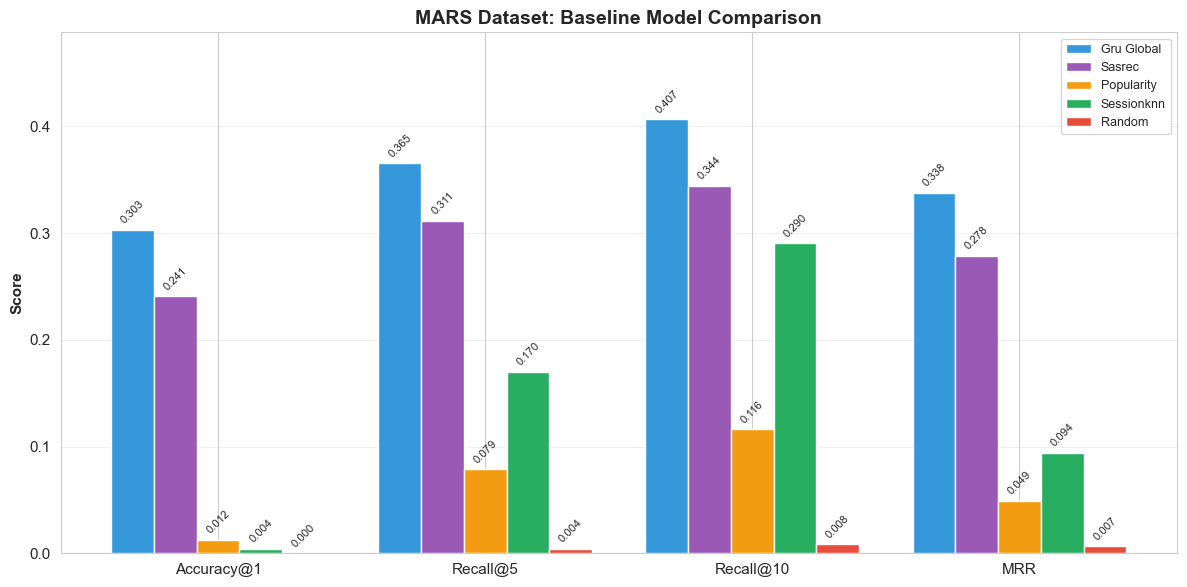

[CELL 06-08] elapsed=0.72s


In [25]:
# [CELL 06-08] Baseline Comparison Plots

t0 = cell_start("CELL 06-08", "Baseline comparison plots")

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

# Define colors for each model
colors = {
    "Random": "#e74c3c",       # Red
    "Popularity": "#f39c12",   # Orange
    "Gru Global": "#3498db",   # Blue
    "Sasrec": "#9b59b6",       # Purple
    "Sessionknn": "#27ae60",   # Green
}

# ========== Figure 1: Grouped Bar Chart (All Metrics) ==========
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ["Accuracy@1", "Recall@5", "Recall@10", "MRR"]
x = np.arange(len(metrics_to_plot))
n_models = len(df_comparison)
width = 0.8 / n_models
multiplier = 0

for model in df_comparison["Model"].tolist():
    values = df_comparison[df_comparison["Model"] == model][metrics_to_plot].values[0]
    offset = width * multiplier
    bars = ax.bar(x + offset, values, width, label=model, color=colors.get(model, "#95a5a6"))
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=45)
    multiplier += 1

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('MARS Dataset: Baseline Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (n_models - 1) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(0, max(df_comparison[metrics_to_plot].max()) * 1.2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
VIZ_DIR = PATHS["REPORTS"] / "06_baselines_mars" / "visualizations"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

fig.savefig(VIZ_DIR / "baseline_comparison_grouped.png", dpi=300, bbox_inches='tight')
fig.savefig(VIZ_DIR / "baseline_comparison_grouped.pdf", bbox_inches='tight')
print(f"[CELL 06-08] Saved: baseline_comparison_grouped.png/pdf")

plt.show()

cell_end("CELL 06-08", t0)


[CELL 06-09] Accuracy@1 bar chart
[CELL 06-09] Saved: accuracy_comparison.png/pdf


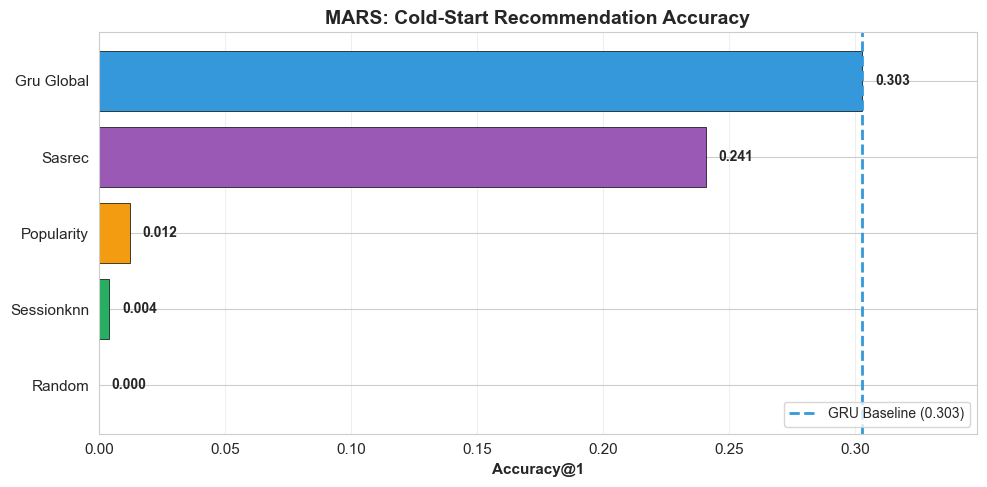

[CELL 06-09] elapsed=0.48s


In [26]:
# [CELL 06-09] Accuracy@1 Horizontal Bar Chart

t0 = cell_start("CELL 06-09", "Accuracy@1 bar chart")

# ========== Figure 2: Horizontal Bar Chart (Accuracy@1 Focus) ==========
fig, ax = plt.subplots(figsize=(10, 5))

# Sort by Accuracy@1
df_sorted = df_comparison.sort_values("Accuracy@1", ascending=True)
models = df_sorted["Model"].tolist()
acc_values = df_sorted["Accuracy@1"].tolist()

# Create horizontal bars
bar_colors = [colors.get(m, "#95a5a6") for m in models]
bars = ax.barh(models, acc_values, color=bar_colors, edgecolor='black', linewidth=0.5)

# Add value labels
for bar, val in zip(bars, acc_values):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', ha='left', fontsize=10, fontweight='bold')

ax.set_xlabel('Accuracy@1', fontweight='bold')
ax.set_title('MARS: Cold-Start Recommendation Accuracy', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(acc_values) * 1.15)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at GRU baseline
gru_acc = df_comparison[df_comparison["Model"] == "Gru Global"]["Accuracy@1"].values[0]
ax.axvline(x=gru_acc, color='#3498db', linestyle='--', linewidth=2, label=f'GRU Baseline ({gru_acc:.3f})')
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()

fig.savefig(VIZ_DIR / "accuracy_comparison.png", dpi=300, bbox_inches='tight')
fig.savefig(VIZ_DIR / "accuracy_comparison.pdf", bbox_inches='tight')
print(f"[CELL 06-09] Saved: accuracy_comparison.png/pdf")

plt.show()

cell_end("CELL 06-09", t0)


[CELL 06-10] Metrics heatmap
[CELL 06-10] Saved: metrics_heatmap.png/pdf


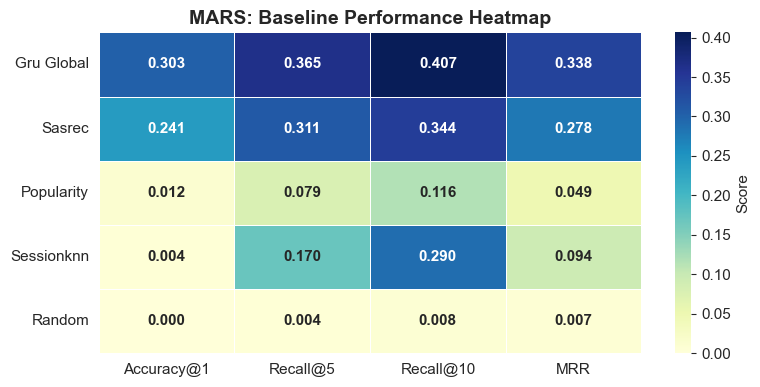

[CELL 06-10] elapsed=0.56s


In [27]:
# [CELL 06-10] Metrics Heatmap

t0 = cell_start("CELL 06-10", "Metrics heatmap")

# ========== Figure 3: Heatmap of All Metrics ==========
fig, ax = plt.subplots(figsize=(8, 4))

# Prepare data for heatmap
heatmap_data = df_comparison.set_index("Model")[metrics_to_plot]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Score'},
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})

ax.set_title('MARS: Baseline Performance Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()

fig.savefig(VIZ_DIR / "metrics_heatmap.png", dpi=300, bbox_inches='tight')
fig.savefig(VIZ_DIR / "metrics_heatmap.pdf", bbox_inches='tight')
print(f"[CELL 06-10] Saved: metrics_heatmap.png/pdf")

plt.show()

cell_end("CELL 06-10", t0)

In [28]:
# [CELL 06-11] Summary & LaTeX Table Export

t0 = cell_start("CELL 06-11", "Summary and LaTeX export")

# ========== Generate LaTeX Table ==========
print("\n[CELL 06-11] ========== LaTeX Table ==========")
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{MARS Dataset: Baseline Model Comparison}")
print("\\label{tab:mars-baselines}")
print("\\begin{tabular}{lcccc}")
print("\\toprule")
print("Model & Acc@1 & Recall@5 & Recall@10 & MRR \\\\")
print("\\midrule")

for _, row in df_comparison.iterrows():
    model_name = row['Model'].replace("Gru Global", "GRU")
    # Bold the best model (GRU)
    if row['Model'] == "Gru Global":
        print(f"\\textbf{{{model_name}}} & \\textbf{{{row['Accuracy@1']:.4f}}} & "
              f"\\textbf{{{row['Recall@5']:.4f}}} & \\textbf{{{row['Recall@10']:.4f}}} & "
              f"\\textbf{{{row['MRR']:.4f}}} \\\\")
    else:
        print(f"{model_name} & {row['Accuracy@1']:.4f} & {row['Recall@5']:.4f} & "
              f"{row['Recall@10']:.4f} & {row['MRR']:.4f} \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

# ========== Save CSV ==========
csv_path = VIZ_DIR / "baseline_comparison.csv"
df_comparison.to_csv(csv_path, index=False)
print(f"\n[CELL 06-11] Saved: baseline_comparison.csv")

# ========== Final Summary ==========
print("\n" + "="*60)
print("NOTEBOOK 06 COMPLETE: MARS Baselines with Comparison")
print("="*60)
print(f"\nDataset: MARS")
print(f"Test Pairs: {len(df_test):,} (cold-start users)")
print(f"Vocabulary: {n_items} items")
print(f"\nBest Baseline: GRU Global")
print(f"  - Accuracy@1:  {metrics['accuracy@1']:.4f}")
print(f"  - Recall@5:    {metrics['recall@5']:.4f}")
print(f"  - Recall@10:   {metrics['recall@10']:.4f}")
print(f"  - MRR:         {metrics['mrr']:.4f}")
print(f"\nVisualizations saved to: {VIZ_DIR}")
print(f"  - baseline_comparison_grouped.png/pdf")
print(f"  - accuracy_comparison.png/pdf")
print(f"  - metrics_heatmap.png/pdf")
print(f"  - baseline_comparison.csv")

cell_end("CELL 06-11", t0)


[CELL 06-11] Summary and LaTeX export

[CELL 06-11] ========== LaTeX Table ==========
\begin{table}[h]
\centering
\caption{MARS Dataset: Baseline Model Comparison}
\label{tab:mars-baselines}
\begin{tabular}{lcccc}
\toprule
Model & Acc@1 & Recall@5 & Recall@10 & MRR \\
\midrule
\textbf{GRU} & \textbf{0.3029} & \textbf{0.3651} & \textbf{0.4066} & \textbf{0.3377} \\
Sasrec & 0.2407 & 0.3112 & 0.3444 & 0.2785 \\
Popularity & 0.0124 & 0.0788 & 0.1162 & 0.0492 \\
Sessionknn & 0.0041 & 0.1701 & 0.2905 & 0.0943 \\
Random & 0.0000 & 0.0041 & 0.0083 & 0.0067 \\
\bottomrule
\end{tabular}
\end{table}

[CELL 06-11] Saved: baseline_comparison.csv

NOTEBOOK 06 COMPLETE: MARS Baselines with Comparison

Dataset: MARS
Test Pairs: 241 (cold-start users)
Vocabulary: 777 items

Best Baseline: GRU Global
  - Accuracy@1:  0.0124
  - Recall@5:    0.0788
  - Recall@10:   0.1162
  - MRR:         0.0492

Visualizations saved to: C:\anonymous-users-mooc-session-meta\reports\06_baselines_mars\visualizations
  - b

---

## Standalone: Load from JSON and Regenerate Plots

Run the cell below **independently** to regenerate all comparison plots from the saved JSON results file. No need to re-run the full notebook.

Loaded results from: C:\anonymous-users-mooc-session-meta\results\mars_baselines_K5_Q10.json
Baselines: ['gru_global', 'sasrec', 'sessionknn', 'random', 'popularity']


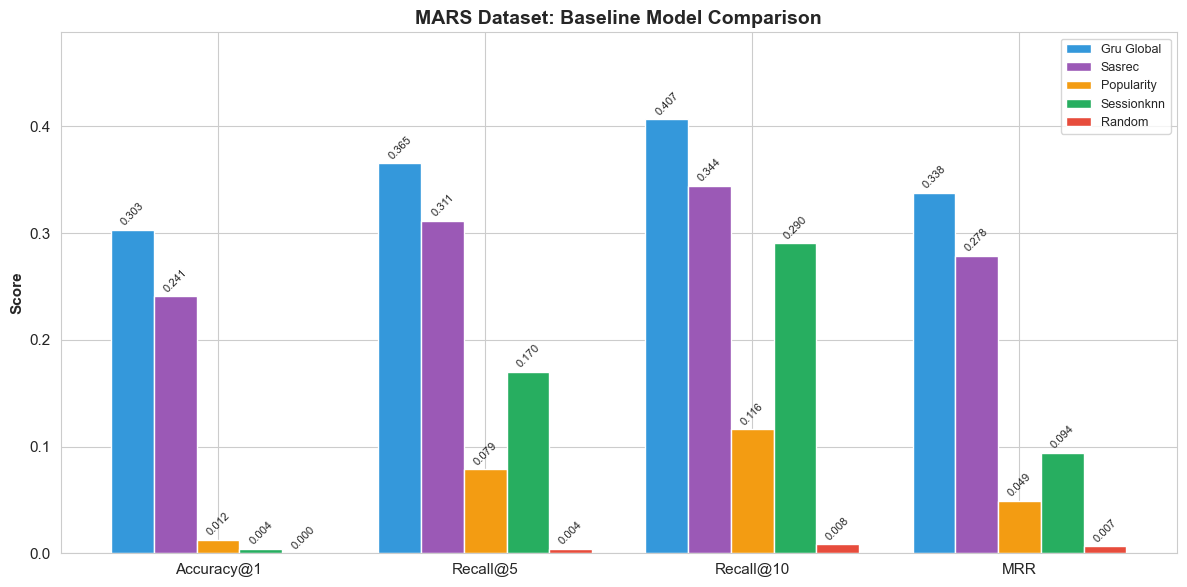

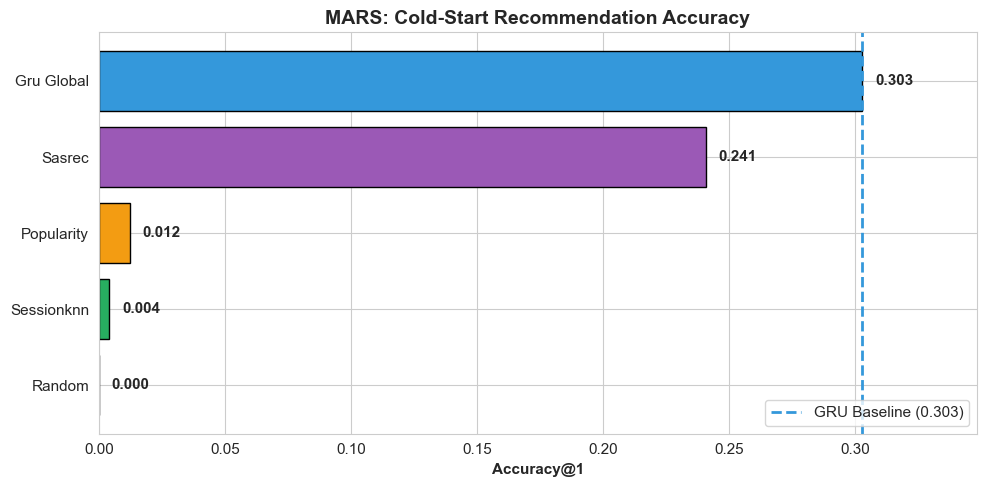

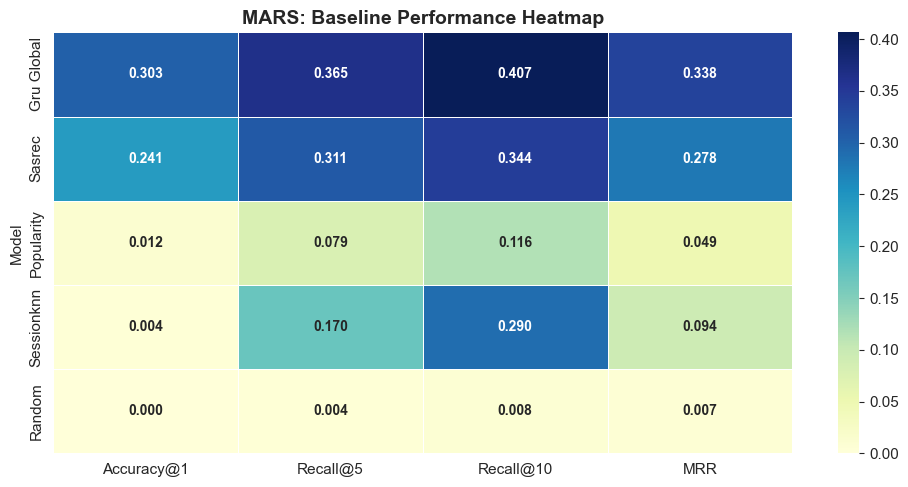


Model                     Acc@1   Recall@5  Recall@10        MRR
------------------------------------------------------------------------
Gru Global               0.3029     0.3651     0.4066     0.3377
Sasrec                   0.2407     0.3112     0.3444     0.2785
Popularity               0.0124     0.0788     0.1162     0.0492
Sessionknn               0.0041     0.1701     0.2905     0.0943
Random                   0.0000     0.0041     0.0083     0.0067

Saved to: C:\anonymous-users-mooc-session-meta\reports\06_baselines_mars\visualizations


In [29]:
# [CELL 06-STANDALONE] Regenerate plots from JSON (run independently)

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Find repo root ===
def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            return p
    raise RuntimeError("Could not find PROJECT_STATE.md")

REPO_ROOT = find_repo_root(Path.cwd())
RESULTS_PATH = REPO_ROOT / "results" / "mars_baselines_K5_Q10.json"
VIZ_DIR = REPO_ROOT / "reports" / "06_baselines_mars" / "visualizations"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# === Load results from JSON ===
with open(RESULTS_PATH, "r") as f:
    results = json.load(f)

print(f"Loaded results from: {RESULTS_PATH}")
print(f"Baselines: {list(results['baselines'].keys())}")

# === Create comparison DataFrame ===
comparison_data = []
for name, metrics in results["baselines"].items():
    comparison_data.append({
        "Model": name.replace("_", " ").title(),
        "Accuracy@1": metrics["accuracy@1"],
        "Recall@5": metrics["recall@5"],
        "Recall@10": metrics["recall@10"],
        "MRR": metrics["mrr"],
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values("Accuracy@1", ascending=False).reset_index(drop=True)

# === Colors for all 5 models ===
colors = {
    "Random": "#e74c3c",       # Red
    "Popularity": "#f39c12",   # Orange
    "Gru Global": "#3498db",   # Blue
    "Sasrec": "#9b59b6",       # Purple
    "Sessionknn": "#27ae60",   # Green
}
metrics_to_plot = ["Accuracy@1", "Recall@5", "Recall@10", "MRR"]

# === Set style ===
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# === Figure 1: Grouped Bar Chart ===
fig1, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
n_models = len(df_comparison)
width = 0.8 / n_models
for i, model in enumerate(df_comparison["Model"].tolist()):
    values = df_comparison[df_comparison["Model"] == model][metrics_to_plot].values[0]
    bars = ax1.bar(x + width * i, values, width, label=model, color=colors.get(model, "#95a5a6"))
    for bar, val in zip(bars, values):
        ax1.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8, rotation=45)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('MARS Dataset: Baseline Model Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * (n_models - 1) / 2)
ax1.set_xticklabels(metrics_to_plot)
ax1.legend(loc='upper right', fontsize=9)
ax1.set_ylim(0, df_comparison[metrics_to_plot].max().max() * 1.2)
plt.tight_layout()
fig1.savefig(VIZ_DIR / "baseline_comparison_grouped.png", dpi=300, bbox_inches='tight')
fig1.savefig(VIZ_DIR / "baseline_comparison_grouped.pdf", bbox_inches='tight')
plt.show()

# === Figure 2: Horizontal Bar Chart ===
fig2, ax2 = plt.subplots(figsize=(10, 5))
df_sorted = df_comparison.sort_values("Accuracy@1", ascending=True)
bar_colors = [colors.get(m, "#95a5a6") for m in df_sorted["Model"]]
bars = ax2.barh(df_sorted["Model"], df_sorted["Accuracy@1"], color=bar_colors, edgecolor='black')
for bar, val in zip(bars, df_sorted["Accuracy@1"]):
    ax2.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontweight='bold')
ax2.set_xlabel('Accuracy@1', fontweight='bold')
ax2.set_title('MARS: Cold-Start Recommendation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlim(0, df_sorted["Accuracy@1"].max() * 1.15)
gru_acc = df_comparison[df_comparison["Model"] == "Gru Global"]["Accuracy@1"].values[0]
ax2.axvline(x=gru_acc, color='#3498db', linestyle='--', linewidth=2, label=f'GRU Baseline ({gru_acc:.3f})')
ax2.legend(loc='lower right')
plt.tight_layout()
fig2.savefig(VIZ_DIR / "accuracy_comparison.png", dpi=300, bbox_inches='tight')
fig2.savefig(VIZ_DIR / "accuracy_comparison.pdf", bbox_inches='tight')
plt.show()

# === Figure 3: Heatmap ===
fig3, ax3 = plt.subplots(figsize=(10, 5))
heatmap_data = df_comparison.set_index("Model")[metrics_to_plot]
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, ax=ax3,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('MARS: Baseline Performance Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
fig3.savefig(VIZ_DIR / "metrics_heatmap.png", dpi=300, bbox_inches='tight')
fig3.savefig(VIZ_DIR / "metrics_heatmap.pdf", bbox_inches='tight')
plt.show()

# === Print Table ===
print("\n" + "="*72)
print(f"{'Model':<20} {'Acc@1':>10} {'Recall@5':>10} {'Recall@10':>10} {'MRR':>10}")
print("-" * 72)
for _, row in df_comparison.iterrows():
    print(f"{row['Model']:<20} {row['Accuracy@1']:>10.4f} {row['Recall@5']:>10.4f} "
          f"{row['Recall@10']:>10.4f} {row['MRR']:>10.4f}")
print("="*72)
print(f"\nSaved to: {VIZ_DIR}")